In [1]:
using DataFrames, NPZ, Arrow, JLD2
using Statistics, NaNMath
using Plots, StatsPlots
using DifferentialEquations, DiffEqParamEstim, Optim

G(z, zstar) = z < zstar ? z : zstar 
@register G(z, zstar)

"""
Interface limited model for biofilm growth,
assumes that nutrients are infinite
"""
function interface_limited(du, u, p, t)
    h = u[1] 
    α, β, hstar = p
    du[1] = α*G.(h, hstar) - β*h 
    return du
end

"""
Fits the experimental data to the interface 
limited interface model. Returns the best parameters
growth, decay and critical height
"""
function fit_model(prob, tdata, zdata, p)
    # Set problem + dummy parameters
    cost_function = build_loss_objective(prob, Tsit5(), L2Loss(tdata, zdata),
                    maxiters=100000, verbose=false)
    result_bfgs = Optim.optimize(cost_function, p, Optim.BFGS())
    min = result_bfgs.minimizer
    return min 
end

function get_data(Df, strain, repl)
    df =  filter(row -> row.Replicate .== repl && row.Strain .== strain, Df);
    return df.Time, df.avg_height
end


_nanfunc(f, A, ::Colon) = f(filter(!isnan, A))
_nanfunc(f, A, dims) = mapslices(a->_nanfunc(f,a,:), A, dims=dims)
nanfunc(f, A; dims=:) = _nanfunc(f, A, dims)

nanfunc (generic function with 1 method)

In [2]:
Df = jldopen("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/profile_database.jld2", "r")["df"];
Df[557+40, 13] = 172
Df[557+43, 13] = 200
Df[557+44, 13] = 190
Df[557+45, 13] = 180
Df[557+46, 13] = 197
Df[557+47, 13] = 210

# Set problem + dummy parameters
u0, p = [0.1], [0.9, 0.1, 20] # Dummy starting conditions
prob = ODEProblem(interface_limited, u0, (0.0, 50.0), p) # Set the problem

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 1-element Vector{Float64}:
 0.1

In [11]:
# Petite yeast 

times = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/times.npy")
A = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/profiles_A.npy")
B = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/profiles_B.npy")
C = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/profiles_C.npy")
hA = nanfunc(mean, A[:, 10000:20000], dims=2)
hB = nanfunc(mean, B[:, 10000:20000], dims=2)
hC = nanfunc(mean, C[:, 10000:20000], dims=2)
p1 = scatter(times[1,:], hA, alpha=0.7, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 230), xlim=(0, 48), title="Petite Yeast")
p1 = scatter!(times[2,:], hB, label = false, alpha=0.7)
p1 = scatter!(times[3,:], hC, label=false, alpha=0.7, grid=false)

p = [0.85, 0.04, 15.0]
u0 = 0.00001
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=times[1,:])
sol = reduce(vcat, sol.u) .+ 2
plot(p1, dpi=300, size=(500, 500))
p1 = plot!(times[1,:], sol, color=:black, linewidth=2, label=false)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/petite_yeast1.svg")


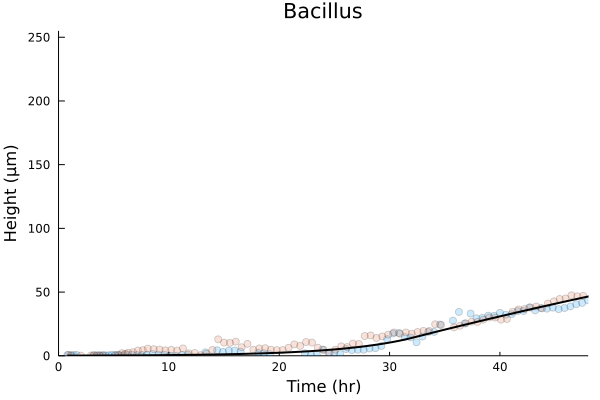

In [245]:
# Bacillus
times = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-30_bacillus/times.npy")
A = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-30_bacillus/profiles_A.npy")
B = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-30_bacillus/profiles_B.npy")
hA = nanfunc(mean, A[:, 10000:20000], dims=2)
hB = nanfunc(mean, B[:, 10000:20000], dims=2)
hB[40:60] .+= -5
scatter(times[1,:], hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 60), xlim=(0, 48), title="Bacillus")
scatter!(times[2,:], hB, label = false, alpha=0.2, grid=false)

p = [0.156, 0.01, 15.0]
u0 = 0.13
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=times[1,:])
sol = reduce(vcat, sol.u)
p2 = plot!(times[1,:], sol, color=:black, linewidth=2, label=false, ylim=(0,255))

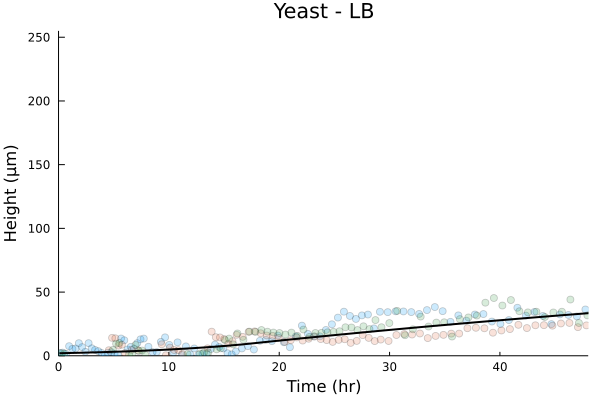

In [246]:
# Yeast 
times = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/times.npy")
A = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/profiles_A.npy")
B = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/profiles_B.npy")
C = npzread("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-07-23_yeast/profiles_C.npy")
hA = nanfunc(mean, A[:, 10000:15000], dims=2)
hB = nanfunc(mean, B[:, 10000:15000], dims=2)
hC = nanfunc(mean, C[:, 10000:15000], dims=2)
hA[20:30] .+= 10
hB[1:30] .+= -15
hC[20:30] .+= -15
hA = abs.(hA)
scatter(times[1,:], hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 50), xlim=(0, 48), title="Yeast - LB")
scatter!(times[2,:], hB, label = false, alpha=0.2)
scatter!(times[3,:], hC, label=false, alpha=0.2, grid=false)

p = [0.1, 0.01, 10.0]
u0 = 2.0
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=times[1,:])
sol = reduce(vcat, sol.u)
p3 = plot!(times[1,:], sol, color=:black, linewidth=2, label=false, ylim=(0, 255))

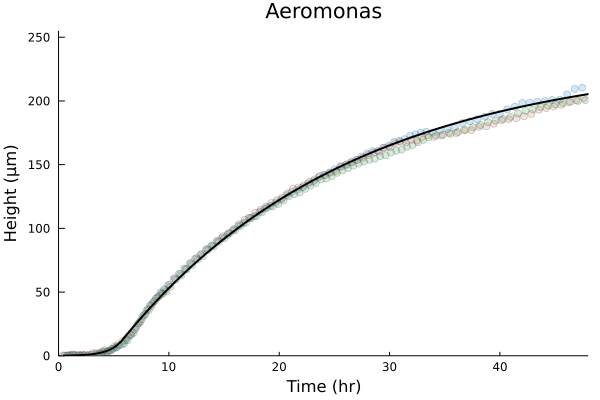

In [247]:
# Aeromonas
tA, hA = get_data(Df, "BGT127", "A")
tB, hB = get_data(Df, "BGT127", "B")
tC, hC = get_data(Df, "BGT127", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="Aeromonas")
scatter!(tB, hB, label = false, alpha=0.2)
scatter!(tC, hC, label=false, alpha=0.2, grid=false)

p = [0.88, 0.048, 12.8]
u0 = 0.1
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=tA)
sol = reduce(vcat, sol.u)
p4 = plot!(tA, sol, color=:black, linewidth=2, label=false, ylim=(0, 255))


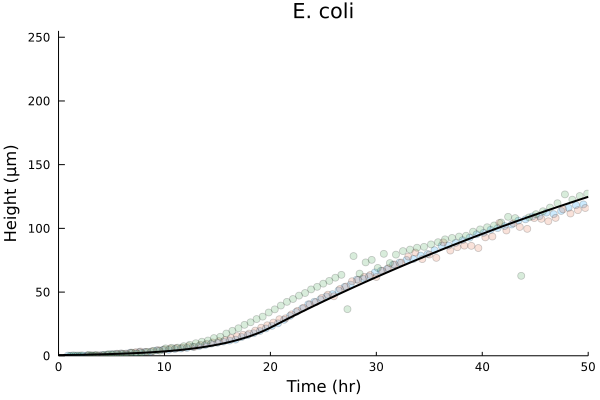

In [248]:
# Ecoli
tA, hA = get_data(Df, "JT305L", "A")
tB, hB = get_data(Df, "JT305L", "B")
tC, hC = get_data(Df, "JT305L", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="E. coli")
scatter!(tB, hB, label = false, alpha=0.2)
scatter!(tC, hC, label=false, alpha=0.2, grid=false)

p = [0.20, 0.0155, 23.1]
u0 = 0.55
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p5 = plot!(sol, color=:black, linewidth=2, xlabel="Time (hr)", label=false, ylim=(0, 255))

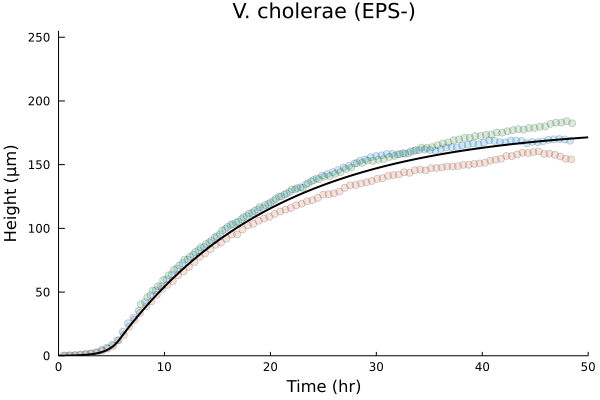

In [249]:
# Vibrio cholerae (EPS-)
tA, hA = get_data(Df, "SN503", "A")
tB, hB = get_data(Df, "SN503", "B")
tC, hC = get_data(Df, "SN503", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="V. cholerae (EPS-)")
scatter!(tB, hB, label = false, alpha=0.2)
scatter!(tC, hC, label=false, alpha=0.2, grid=false)

p = [0.95, 0.067, 12.7]
u0 = 0.08
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p6 = plot!(sol, color=:black, linewidth=2, xlabel="Time (hr)", label=false, ylim=(0, 255))

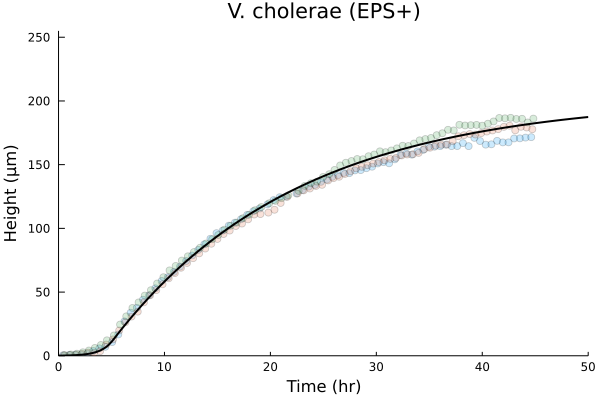

In [250]:
# Vibrio cholerae (EPS+)
tA, hA = get_data(Df, "JT1080", "A")
tB, hB = get_data(Df, "JT1080", "B")
tC, hC = get_data(Df, "JT1080", "C")

hA = abs.(hA)
scatter(tA, hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="V. cholerae (EPS+)")
scatter!(tB, hB, label = false, alpha=0.2)
scatter!(tC, hC, label=false, alpha=0.2, grid=false)

p = [0.96, 0.057, 12.0]
u0 = 0.12
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p7 = plot!(sol, color=:black, linewidth=2, label=false, xlabel="Time (hr)", ylim=(0, 255))

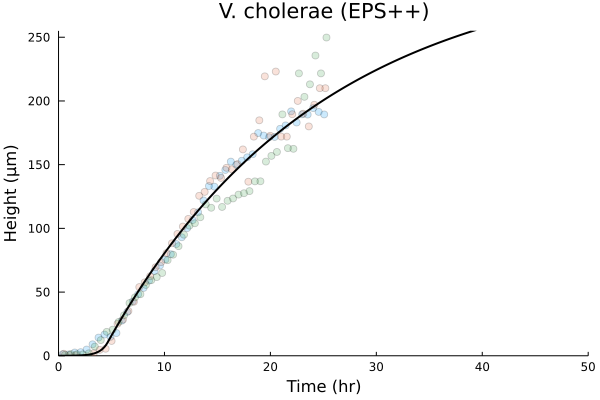

In [252]:
# Vibrio cholerae (EPS++)
tA, hA = get_data(Df, "BH1543", "A")
tB, hB = get_data(Df, "BH1543", "B")
tC, hC = get_data(Df, "BH1543", "C")

hB[40] = 172
hB[43] = 200
hB[44] = 190
hB[45] = 180
hB[46] = 197
hB[47] = 210

hA = abs.(hA)
scatter(tA, hA, alpha=0.2, xlabel="Time (hr)", ylabel="Height (μm)", label=false, ylim=(0, 250), xlim=(0, 48), title="V. cholerae (EPS++)")
scatter!(tB, hB, label = false, alpha=0.2)
scatter!(tC, hC, label=false, alpha=0.2, grid=false)

p = [1.4, 0.05, 11.0]
u0 = 0.02
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p8 = plot!(sol, color=:black, linewidth=2, label=false, xlabel="Time (hr)", ylim=(0, 255))

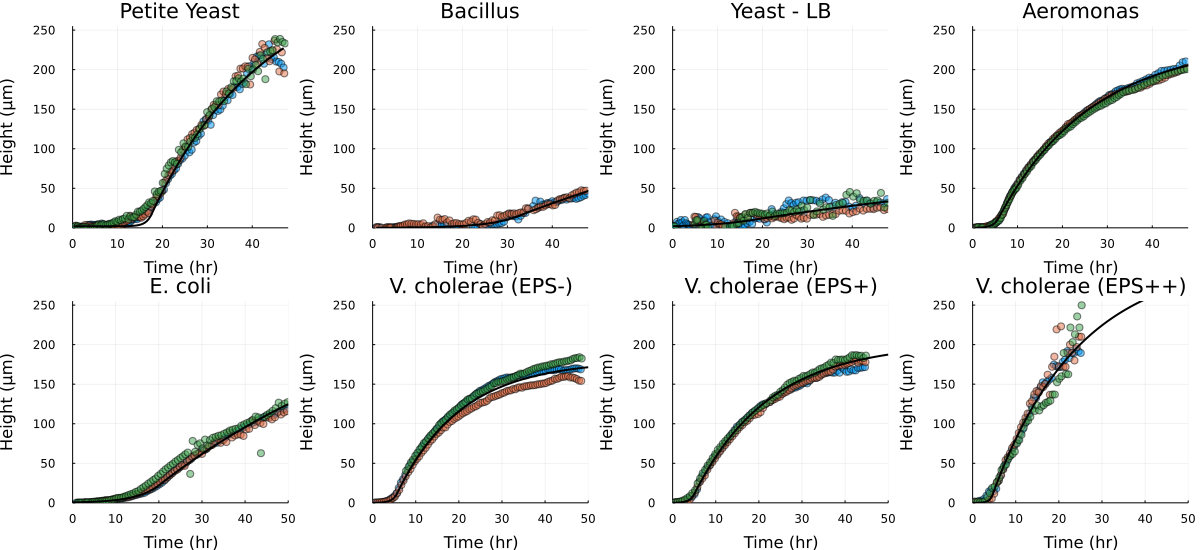

In [236]:
plot(p1, p2, p3, p4, p5, p6, p7, p8, layout = (2, 4), size=(1200,550), left_margin=4mm, bottom_margin=3mm)

In [254]:
plot(p6, p7, p8, p5, p4, p2, p1, p3, layout = (2, 4), size=(1100,550), left_margin=4mm, bottom_margin=3mm, dpi=500)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/interface_all.svg")

In [7]:
function interface_limited2(du, u, p, t)
    h = u 
    α, β, hstar = p
    du = α*G.(h, hstar) - β*h 
    return du
end

interface_limited2 (generic function with 1 method)

In [38]:
p = [0.0, 0.048, 12.8]

p1 = plot()
start_heights = [272.76, 281.99, 210.27, 176.35, 160.26, 163.54, 135.52, 138.71, 144.30]
my_colors = [1,1,1,2,2,2,3,3,3]
for i=1:9
    prob = ODEProblem(interface_limited, [start_heights[i]], (0.0, 50.0), p) # Set the problem
    sol = solve(prob, saveat=0.1)
    #sol = reduce(vcat, sol.u)
    p1 = plot!(sol, color=my_colors[i], linewidth=1.5, label=false, ylim=(10, 300), alpha=0.8)
end
pleft = plot(p1, xlabel="Time [hr]", ylabel="Height [μm]")
pright = plot(p1, yscale=:log10, xlabel="Time [hr]", ylabel="Height [μm]")
plot(pleft, pright, size=(1000, 300), left_margin=4mm, bottom_margin=4mm, dpi=300)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/decay_prediction.svg")

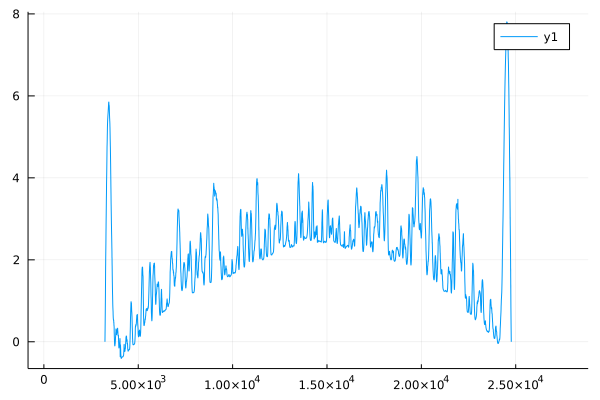

In [32]:
plot(C[15,:])

In [33]:
yeast_profile = C[15,:]

28000-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [91]:
using Polynomials
" Substract a polynomial of degree *deg* from the array y"
function subpoly(y, deg)
  x = Array(range(1, length(y), step=1))  # temp x array for fitting
  flat = fit(x, y, deg)                   # fitting 
  myfit = flat.(x)                        # lower dimension
  sub = y-myfit                           # substract 
  return sub
end
s2 = subpoly(yeast_profile[5250:14750], 2)
s3 = subpoly(bacteria_profile[12500:22000], 2)

9501-element Vector{Float64}:
  0.005215622600070802
  0.00887250394321093
  0.013197090193397543
  0.01824270048072485
  0.02357087755086873
  0.02936589501931408
  0.03560743636721497
  0.04213762631746931
  0.048712020049046956
  0.05519987674431448
  0.062416136807412315
  0.06995408810118597
  0.07614686140623661
  ⋮
 -0.5557025374615865
 -0.5604600814788228
 -0.5661043785030966
 -0.5712431088961267
 -0.5771763661001135
 -0.5839551458411947
 -0.5904349374143472
 -0.596655975932924
 -0.6025424403846653
 -0.6084588584868058
 -0.6140862506929139
 -0.618428034338443

In [121]:
x = Array(1:9501)*1.173e-1
plot(x,s2, size=(550, 200), linewidth=1.5, label="Petite Yeast", left_margin=3mm, dpi=300)
plot!(x,s3, linewidth=1.5, grid=false, xlabel="X [μm]", ylabel="ΔH [μm]", label="V cholerae", bottom_margin=3mm)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/binary_profile.svg")

In [108]:
using Plots.Measures

In [58]:
sum(isnan.(yeast_profile[3250:24700]))

0

In [70]:
bacteria = npzread("/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-08-27_jt305/Clean/profiles_A.npy")

bacteria_profile = bacteria[30,:]

40500-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

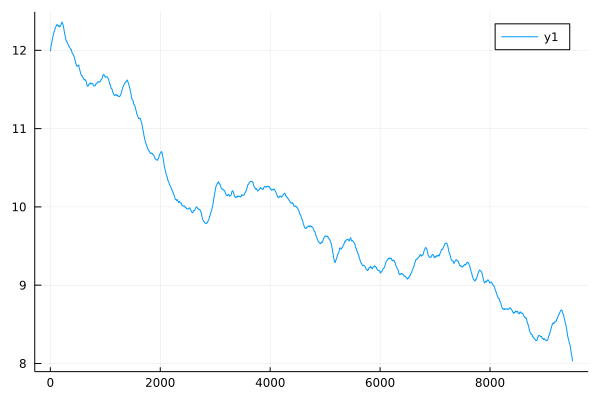

In [74]:
plot(bacteria_profile[12500:22000])